### Section 4.2: Dark frames

In [146]:
# Importing necessary packages
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy import stats, optimize

In [147]:
def create_master_dark(file_template, num_frames):
    """
    Create a master dark frame by median-combining dark frames.
    
    :param file_template: Template path for the dark frame files with placeholders for the frame number.
    :type file_template: str
    :param num_frames: The number of dark frames to combine.
    :type num_frames: int
    :return: Master dark frame (2D numpy array), Stack of individual dark frames (3D numpy array)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # List to store the data from each dark frame
    dark_frames_data = []
    # Loop through each dark frame and read the data
    for i in range(num_frames):
        # Construct the file name based on the frame number
        file_path = file_template.format(i)
        # Open the FITS file and extract the data
        with fits.open(file_path) as hdul:
            dark_frames_data.append(hdul[0].data)
    # Stack the frames into a 3D array (stack of 2D frames)
    stacked_frames = np.stack(dark_frames_data, axis=0)
    # Calculate the median across the stack (axis=0)
    master_dark_frame = np.median(stacked_frames, axis=0)
    
    return master_dark_frame, stacked_frames


# Template for the file names (with placeholder for frame number)
file_template = r"..\FITS_Files\3.2.3_10_dark_frames_30_sec.{:08d}.DARK.FIT"
# Number of dark frames to combine
num_frames = 10
# Create the master dark frame and get the individual frames
master_dark_frame, dark_frames = create_master_dark(file_template, num_frames)

In [148]:
# Calculate the median value of the master dark frame
median_value = np.median(master_dark_frame)

# Output the median value
print(f"Median value of the master dark frame: {median_value}")

Median value of the master dark frame: 1022.0


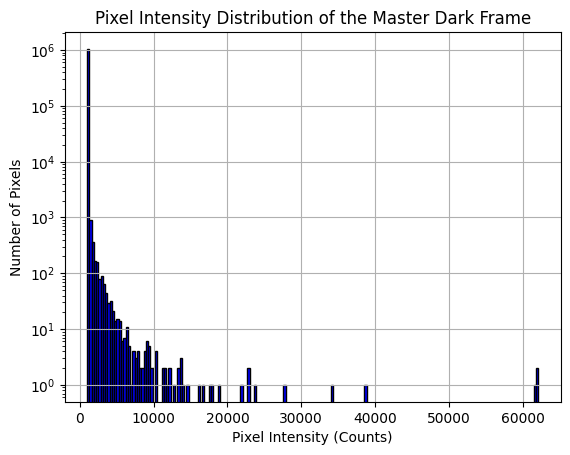

In [149]:
# Flattening the data into a 1D array
flattened_data = master_dark_frame.flatten()

# Plot the histogram of pixel intensities for the median dark frame
plt.figure()
plt.hist(flattened_data, range = (np.min(flattened_data), np.max(flattened_data)), bins=200, log=True, color='blue', edgecolor='black')
plt.title('Pixel Intensity Distribution of the Master Dark Frame')
plt.xlabel('Pixel Intensity (Counts)')
plt.ylabel('Number of Pixels')
plt.grid(True)

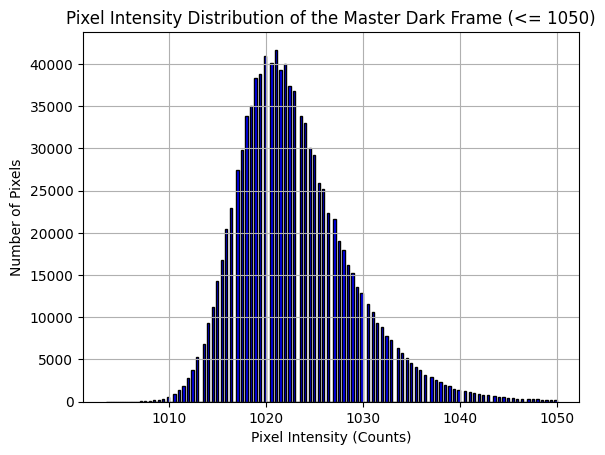

In [150]:
# Filtering the data to include only values less than or equal to the median maximum
med_max = 1050
filtered_data = flattened_data[flattened_data <= med_max]

# Plot the new histogram 
plt.figure()
plt.hist(filtered_data, range = (np.min(filtered_data), np.max(filtered_data)), bins=200, color='blue', edgecolor='black')
plt.title('Pixel Intensity Distribution of the Master Dark Frame (<= 1050)')
plt.xlabel('Pixel Intensity (Counts)')
plt.ylabel('Number of Pixels')
plt.grid(True)

In [151]:
# Initialize lists for hot and warm pixels
hot_pixels = []
warm_pixels = []

# Iterate over each pixel in the median dark frame
for i in range(master_dark_frame.shape[0]):
    for j in range(master_dark_frame.shape[1]):
        if master_dark_frame[i, j] >= 20000:  # Hot pixel threshold
            hot_pixels.append([i, j])  # Store as [row, col] (i, j)
        elif 10000 < master_dark_frame[i, j] < 20000:  # Warm pixel range
            warm_pixels.append([i, j])  # Store as [row, col] (i, j)

# Calculate the total number of pixels in the median dark frame
total_pixels = master_dark_frame.size

# Calculate the fraction of rejected pixels
fraction_of_rejected_pixels = (len(hot_pixels) + len(warm_pixels)) / total_pixels

# Output the results
print(f"Hot pixels: {hot_pixels}")
print(f"Warm pixels: {warm_pixels}")
print(f"Fraction of rejected pixels: {len(hot_pixels) + len(warm_pixels)}/{total_pixels} or {fraction_of_rejected_pixels*100}%")

Hot pixels: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [383, 665], [396, 913], [400, 444], [402, 464], [443, 329], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]
Fraction of rejected pixels: 36/1048576 or 0.0034332275390625%


In [152]:
# Initialize lists for visibility checks
hot_pixels_in_all_frames = []
warm_pixels_in_all_frames = []
hot_pixels_in_median_only = []
warm_pixels_in_median_only = []
hot_pixels_in_both = []
warm_pixels_in_both = []

# Check each pixel in the list of hot and warm pixels
for pixel in hot_pixels:
    i, j = pixel
    appears_in_all_frames = all(dark_frame[i, j] >= 20000 for dark_frame in dark_frames)
    appears_in_median_only = (master_dark_frame[i, j] >= 20000) and not appears_in_all_frames
    
    if appears_in_all_frames:
        hot_pixels_in_all_frames.append(pixel)
    elif appears_in_median_only:
        hot_pixels_in_median_only.append(pixel)
    else:
        hot_pixels_in_both.append(pixel)

for pixel in warm_pixels:
    i, j = pixel
    appears_in_all_frames = all(10000 < dark_frame[i, j] < 20000 for dark_frame in dark_frames)
    appears_in_median_only = (10000 < master_dark_frame[i, j] < 20000) and not appears_in_all_frames
    
    if appears_in_all_frames:
        warm_pixels_in_all_frames.append(pixel)
    elif appears_in_median_only:
        warm_pixels_in_median_only.append(pixel)
    else:
        warm_pixels_in_both.append(pixel)

# Output the results
print(f"Hot pixels in all frames: {hot_pixels_in_all_frames}")
print(f"Warm pixels in all frames: {warm_pixels_in_all_frames}")
print(f"Hot pixels only in median: {hot_pixels_in_median_only}")
print(f"Warm pixels only in median: {warm_pixels_in_median_only}")
print(f"Hot pixels in both median and some frames: {hot_pixels_in_both}")
print(f"Warm pixels in both median and some frames: {warm_pixels_in_both}")

Hot pixels in all frames: [[67, 968], [189, 347], [350, 36], [359, 705], [409, 329], [495, 198], [610, 230], [718, 468], [915, 766], [1022, 31]]
Warm pixels in all frames: [[28, 129], [77, 1023], [87, 911], [110, 5], [216, 431], [321, 153], [327, 395], [396, 913], [400, 444], [490, 453], [497, 265], [551, 987], [565, 909], [608, 987], [660, 95], [687, 949], [797, 107], [833, 641], [858, 263], [909, 662], [967, 889], [992, 374], [998, 550]]
Hot pixels only in median: []
Warm pixels only in median: [[383, 665], [402, 464], [443, 329]]
Hot pixels in both median and some frames: []
Warm pixels in both median and some frames: []


In [153]:
def combine_dark_frames_with_bias(dark_file_template, exposure_times, bias_file):
    """
    Combine dark frames with varying exposure times with the bias frame by adding their data together.
    
    :param dark_file_template: Template path for the dark frame files with placeholders for the exposure time.
    :type dark_file_template: str
    :param exposure_times: List of exposure times for the dark frames.
    :type exposure_times: list
    :param bias_file: Path to the bias frame FITS file.
    :type bias_file: str
    :return: Stacked combined dark and bias frames (3D numpy array), Stacked individual dark frames (3D numpy array)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Open the bias frame and get the data
    with fits.open(bias_file) as hdul_bias:
        bias_data = hdul_bias[0].data
    # Initialize lists to hold the combined data and individual dark frame data
    combined_data = []
    individual_dark_frames = []
    # Loop over each exposure time and process the corresponding dark frame
    for exposure_time in exposure_times:
        # Construct the file path for the current dark frame
        dark_file_path = dark_file_template.format(exposure_time)
        # Open the dark frame and get the data
        with fits.open(dark_file_path) as hdul_dark:
            dark_data = hdul_dark[0].data
        # Store the individual dark frame data
        individual_dark_frames.append(dark_data)
        # Add the dark frame to the bias frame
        combined_frame = dark_data + bias_data
        # Store the combined frame data
        combined_data.append(combined_frame)
    # Stack the combined frames and individual dark frames into 3D arrays
    stacked_combined_data = np.stack(combined_data, axis=0)
    stacked_individual_dark_frames = np.stack(individual_dark_frames, axis=0)
    
    return stacked_combined_data, stacked_individual_dark_frames

# Example usage
dark_file_template = r"../FITS_Files/3.2.2_dark_frame_{:d}_sec.00000000.DARK.FIT"
exposure_times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # List of exposure times for the dark frames
bias_file = r"../FITS_Files/3.1_bias.00000011.BIAS.FIT"

# Combine the dark frames with the bias frame
stacked_combined_data, stacked_dark_frames = combine_dark_frames_with_bias(dark_file_template, exposure_times, bias_file)

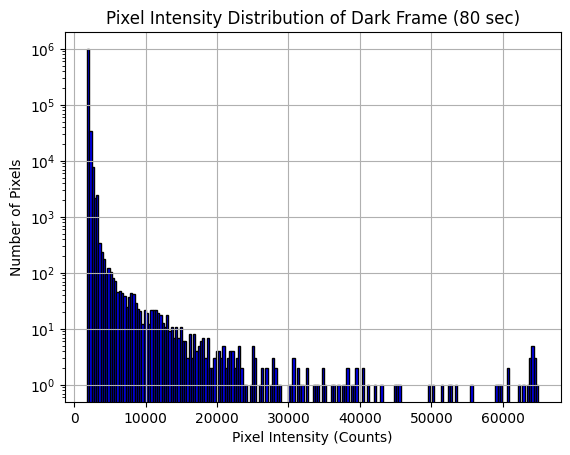

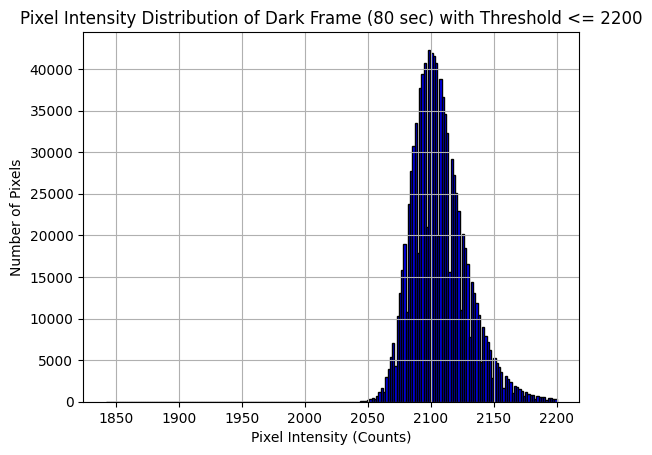

In [155]:
# Define the threshold for filtering
threshold = 2200
# Filtered exposure times
filtered_exposure_times = [80]  # Only putting one time here to make the output not cluttered with graphs of all exposure times

# Process each filtered dark frame individually
for exposure_time in filtered_exposure_times:
    # Get the index of the current exposure time
    i = exposure_times.index(exposure_time)
    # Select the dark frame and combined frame for the current exposure time
    dark_frame = stacked_dark_frames[i]
    combined_frame = stacked_combined_data[i]
    # Flatten the combined frame data into a 1D array
    flattened_combined_data = combined_frame.flatten()
    # Plot the histogram of pixel intensities for the combined dark frame (unfiltered)
    plt.figure()
    plt.hist(flattened_combined_data, bins=200, range=(np.min(flattened_combined_data), np.max(flattened_combined_data)), log=True, color='blue', edgecolor='black')
    plt.title(f'Pixel Intensity Distribution of Dark Frame ({exposure_time} sec)')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.grid(True)
    plt.show()

    # Filter the data based on the threshold
    filtered_data = flattened_combined_data[flattened_combined_data <= threshold]
    # Plot the histogram of pixel intensities for the filtered dark frame
    plt.figure()
    plt.hist(filtered_data, bins=200, range=(np.min(filtered_data), np.max(filtered_data)), color='blue', edgecolor='black')
    plt.title(f'Pixel Intensity Distribution of Dark Frame ({exposure_time} sec) with Threshold <= {threshold}')
    plt.xlabel('Pixel Intensity (Counts)')
    plt.ylabel('Number of Pixels')
    plt.grid(True)
    plt.show()
    

In [138]:
# Define the filter ranges for each frame
filter_ranges = [1050, 2100, 2200, 2275, 2400, 2450, 2550, 2600, 2700, 2750, 2850, 2900, 3050]
exposure_times = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # Include 0 for bias frame
bias_index = 0  # Index for the bias frame

mean_counts_lim = []
st_devs_lim = []
stat_uncs_lim = []

# Include bias frame data separately
with fits.open(bias_file) as hdul_bias:
    bias_data = hdul_bias[0].data
bias_flat_data = bias_data.flatten()

# List of all frame data, including the bias frame
all_frames = [bias_flat_data] + [frame.flatten() for frame in stacked_dark_frames]

# Calculate mean, standard deviation, and statistical uncertainty
for i, flat_data in enumerate(all_frames):
    filter_max = filter_ranges[i]
    # Filter data based on the filter range
    filtered_data = flat_data[flat_data <= filter_max]
    # Calculate mean, standard deviation, and statistical uncertainty if there is data
    if filtered_data.size > 0:
        mean = np.mean(filtered_data)
        st_dev = stats.tstd(filtered_data, ddof=1)
        stat_unc = mean / np.sqrt(len(filtered_data))
    else:
        mean = st_dev = stat_unc = np.nan  # Handle the case where filtered data is empty
    
    mean_counts_lim.append(mean)
    st_devs_lim.append(st_dev)
    stat_uncs_lim.append(stat_unc)
    
    # Print results for each frame
    print(f"Exposure Time: {exposure_times[i]} sec, Max Filter: {filter_max}")
    print(f"Mean Counts: {mean}, Standard Deviation: {st_dev}, Statistical Uncertainty: {stat_unc}")

Exposure Time: 0 sec, Max Filter: 1050
Mean Counts: 1002.9957325339666, Standard Deviation: 7.718027122092835, Statistical Uncertainty: 0.9796809712977722
Exposure Time: 10 sec, Max Filter: 2100
Mean Counts: 1010.7619705318742, Standard Deviation: 19.41899813036743, Statistical Uncertainty: 0.9871612060190114
Exposure Time: 20 sec, Max Filter: 2200
Mean Counts: 1018.9100231267698, Standard Deviation: 25.594116234131928, Statistical Uncertainty: 0.9952381506431526
Exposure Time: 30 sec, Max Filter: 2275
Mean Counts: 1027.1538055613871, Standard Deviation: 30.65696413525538, Statistical Uncertainty: 1.0033842291615291
Exposure Time: 40 sec, Max Filter: 2400
Mean Counts: 1035.3524735977157, Standard Deviation: 36.87283287187875, Statistical Uncertainty: 1.0114481867611396
Exposure Time: 50 sec, Max Filter: 2450
Mean Counts: 1042.8813619339592, Standard Deviation: 42.34734492688176, Statistical Uncertainty: 1.018856728439517
Exposure Time: 60 sec, Max Filter: 2550
Mean Counts: 1050.9839809

In [139]:
mean_counts_whole = []
st_devs_whole = []
stat_uncs_whole = []

# Calculate mean, standard deviation, and statistical uncertainty for unfiltered data
for i, flat_data in enumerate(all_frames):
    # No filter applied here
    unfiltered_data = flat_data
    # Calculate mean, standard deviation, and statistical uncertainty if there is data
    if unfiltered_data.size > 0:
        mean = np.mean(unfiltered_data)
        st_dev = stats.tstd(unfiltered_data, ddof=1)  # Sample standard deviation
        stat_unc = mean / np.sqrt(len(unfiltered_data))
    else:
        mean = st_dev = stat_unc = np.nan  # Handle the case where unfiltered data is empty
    
    mean_counts_whole.append(mean)
    st_devs_whole.append(st_dev)
    stat_uncs_whole.append(stat_unc)
    
    # Print results for each frame
    print(f"Exposure Time: {exposure_times[i]} sec")
    print(f"Mean Counts: {mean}, Standard Deviation: {st_dev}, Statistical Uncertainty: {stat_unc}")

Exposure Time: 0 sec
Mean Counts: 1003.057149887085, Standard Deviation: 14.869272117575331, Statistical Uncertainty: 0.9795479979366064
Exposure Time: 10 sec
Mean Counts: 1011.3171682357788, Standard Deviation: 98.23146788071946, Statistical Uncertainty: 0.9876144221052527
Exposure Time: 20 sec
Mean Counts: 1020.2279901504517, Standard Deviation: 123.83317820423197, Statistical Uncertainty: 0.9963163966313004
Exposure Time: 30 sec
Mean Counts: 1029.3027658462524, Standard Deviation: 156.6409813639801, Statistical Uncertainty: 1.005178482271731
Exposure Time: 40 sec
Mean Counts: 1038.3151874542236, Standard Deviation: 191.37723182264267, Statistical Uncertainty: 1.0139796752482653
Exposure Time: 50 sec
Mean Counts: 1046.6994800567627, Standard Deviation: 230.4463528375717, Statistical Uncertainty: 1.0221674609929323
Exposure Time: 60 sec
Mean Counts: 1055.6110725402832, Standard Deviation: 258.9103370397622, Statistical Uncertainty: 1.0308701880276203
Exposure Time: 70 sec
Mean Counts:

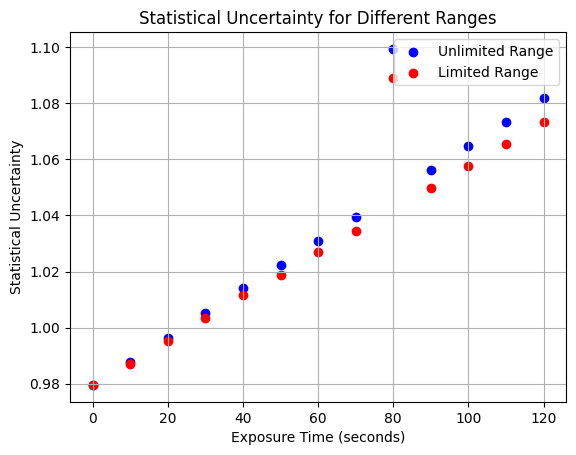

In [140]:
plt.figure()
plt.scatter(exposure_times, stat_uncs_whole, label="Unlimited Range", color='blue')
plt.scatter(exposure_times, stat_uncs_lim, label="Limited Range", color='red')
plt.title("Statistical Uncertainty for Different Ranges")
plt.xlabel("Exposure Time (seconds)")
plt.ylabel("Statistical Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

Dark Current Rate: 1.6909 ± 0.2015 e-/p/s
Offset: 1003.6810 ± 7.1230


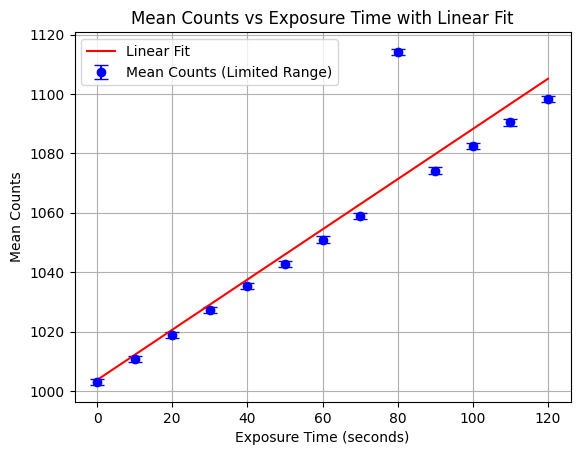

In [141]:
# Define the linear function for fitting with documentation
def linear_model(exposure, dark_current_rate, offset):
    """
    Compute the predicted mean counts for a given exposure time based on a linear model.

    :param exposure: The amount of time the frame was exposed for.
    :type exposure: (array-like)
    :param dark_current_rate: The rate at which dark current accumulates.
    :type dark_current_rate: float :unit: electrons per pixel per second (e/p/s)
    :param offest: The number of electrons the measurements are offset by.
    :type offest: float 
    :return: The predicted mean counts for the given exposure times based on the linear model.
    :rtype: np.ndarray
    """
    return dark_current_rate * exposure + offset

# Perform linear regression, along with the uncertainties of each values 
params, covariance = optimize.curve_fit(linear_model, exposure_times, mean_counts_lim)
dark_current_rate, offset = params
uncertainty_in_dcr = np.sqrt(covariance[0][0])
uncertainty_in_offset = np.sqrt(covariance[1][1])

# Gain of STL-1001E camera
gain = 2  # e-/ADU

# Adjust dark current rate and its uncertainty by the gain
dark_current_rate_gain_adjusted = dark_current_rate * gain
dark_current_rate_uncertainty = uncertainty_in_dcr * gain

# Print results
print(f"Dark Current Rate: {dark_current_rate_gain_adjusted:.4f} ± {dark_current_rate_uncertainty:.4f} e-/p/s")
print(f"Offset: {offset:.4f} ± {uncertainty_in_offset:.4f}")

# Generate fitted values
fitted_counts = linear_model(np.array(exposure_times), *params)

# Plot the mean counts against exposure time
plt.figure()
plt.errorbar(exposure_times, mean_counts_lim, yerr=stat_uncs_lim, fmt='o', label='Mean Counts (Limited Range)', color='blue', capsize=5)
plt.plot(exposure_times, fitted_counts, 'r-', label=f'Linear Fit')
plt.title('Mean Counts vs Exposure Time with Linear Fit')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Mean Counts')
plt.legend()
plt.grid(True)
plt.show()

The farthest mean count is 39.286 sigmas away.


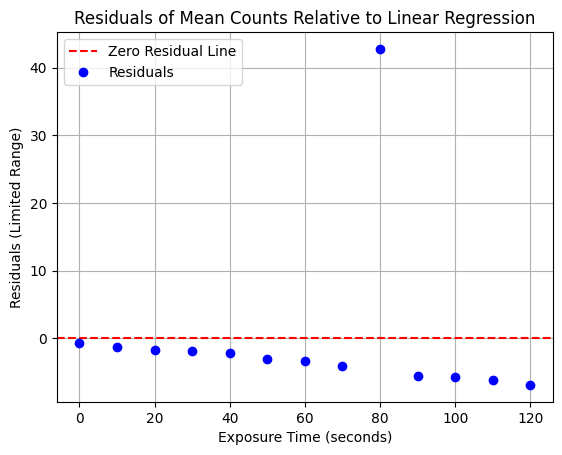

In [142]:
# Calculate residuals by subtracting predicted values from observed mean counts
residuals = []
for i, count in enumerate(mean_counts_lim):
    predicted_value = linear_model(exposure_times[i], dark_current_rate, offset)
    residuals.append(count - predicted_value)

# Calculate the distance of residuals in terms of sigmas
sigma_distances = np.abs(np.array(residuals)) / np.array(stat_uncs_lim)

# Output the farthest mean count in terms of sigmas
farthest_sigma = np.max(sigma_distances)
farthest_index = np.argmax(sigma_distances)
farthest_mean_count = mean_counts_lim[farthest_index]
print(f"The farthest mean count is {farthest_sigma:.3f} sigmas away.")

# Plot the residuals
plt.figure()
plt.errorbar(exposure_times, residuals, fmt='o', color='blue', capsize=5, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals of Mean Counts Relative to Linear Regression')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Residuals (Limited Range)')
plt.legend()
plt.grid(True)
plt.show()

Dark Current Rate: 3.3379 ± 0.0144 e-/p/s


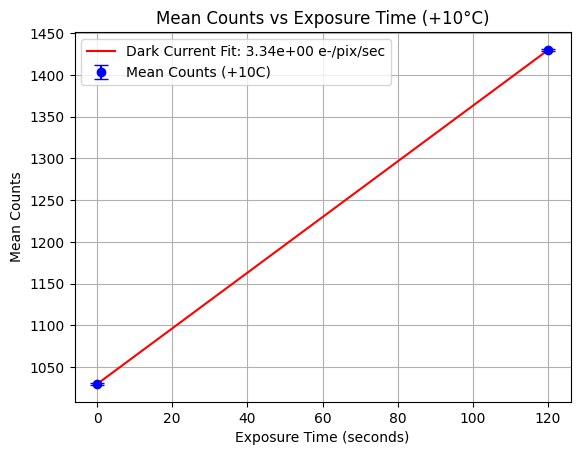

In [143]:
# File paths our Bias Frame and our Dark frame at +10° C
bias_file_10C = r"..\FITS_Files\3.2.4_bias_frame_+10C.00000000.BIAS.FIT"
dark_file_10C_120s = r"..\FITS_Files\3.2.4_dark_frame_120_sec_+10C.00000000.DARK.FIT"

# Define filter limits
bias_filter_max = 1050
dark_filter_max = 3050
exposure_time_dark = 120  # seconds

# Load the bias frame data at +10v C
with fits.open(bias_file_10C) as hdul_bias_10C:
    bias_data_10C = hdul_bias_10C[0].data
bias_flat_data_10C = bias_data_10C.flatten()

# Load the dark frame data at +10°C, 120 sec exposure
with fits.open(dark_file_10C_120s) as hdul_dark_10C_120s:
    dark_data_10C_120s = hdul_dark_10C_120s[0].data
dark_flat_data_10C_120s = dark_data_10C_120s.flatten()

# Filter the bias and dark frame data based on the filter ranges
bias_filtered_10C = bias_flat_data_10C[bias_flat_data_10C <= bias_filter_max]
dark_filtered_10C_120s = dark_flat_data_10C_120s[dark_flat_data_10C_120s <= dark_filter_max]

# Calculate mean, standard deviation, and statistical uncertainty for the bias frame
mean_bias_10C = np.mean(bias_filtered_10C)
st_dev_bias_10C = np.std(bias_filtered_10C, ddof=1)
stat_unc_bias_10C = mean_bias_10C / np.sqrt(len(bias_filtered_10C))

# Calculate mean, standard deviation, and statistical uncertainty for the dark frame
mean_dark_10C_120s = np.mean(dark_filtered_10C_120s)
st_dev_dark_10C_120s = np.std(dark_filtered_10C_120s, ddof=1)
stat_unc_dark_10C_120s = mean_dark_10C_120s / np.sqrt(len(dark_filtered_10C_120s))

# Calculate the dark current (slope) and its uncertainty
dark_current = (mean_dark_10C_120s - mean_bias_10C) / exposure_time_dark
uncertainty_dark_current = np.sqrt(stat_unc_dark_10C_120s**2 + stat_unc_bias_10C**2) / exposure_time_dark

# Print the calculated dark current and its uncertainty
print(f"Dark Current Rate: {dark_current:.4f} ± {uncertainty_dark_current:.4f} e-/p/s")

# Plot the points and the dark current line
exposure_times = [0, exposure_time_dark]
mean_counts = [mean_bias_10C, mean_dark_10C_120s]
stat_uncs = [stat_unc_bias_10C, stat_unc_dark_10C_120s]

# Generate predicted counts using the dark current model
predicted_counts = linear_model(np.array(exposure_times), dark_current, mean_bias_10C)

# Plot the mean counts vs exposure time
plt.figure()
plt.errorbar(exposure_times, mean_counts, yerr=stat_uncs, fmt='o', color='blue', capsize=5, label='Mean Counts (+10C)')
plt.plot(exposure_times, predicted_counts, color='red', label=f"Dark Current Fit: {dark_current:.2e} e-/pix/sec")
plt.title('Mean Counts vs Exposure Time (+10°C)')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Mean Counts')
plt.legend()
plt.grid(True)
plt.show()